In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
from glob import iglob
import matplotlib as mpl
from scipy.io import mmread
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['legend.markerscale'] = 4
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.dpi'] = 100

sns.set_style('ticks')
sns.set_palette('Set1')

# Check cell identify using scRNA-seq

In [3]:
count = mmread('RNA/outs/Solo.out/Gene/filtered/matrix.mtx')
genes = [i.split('\t')[1] for i in open('RNA/outs/Solo.out/Gene/filtered/features.tsv')]
cells = [i.strip() for i in open('RNA/outs/Solo.out/Gene/filtered/barcodes.tsv')]

rna = pd.DataFrame(data=count.toarray(),
                   index=genes,
                   columns=cells)

In [4]:
# binarise RNA data and perform Latent Semantic Indexing analysis

bin_rna = rna.where(rna < 1, 1)
tfidf = TfidfTransformer(norm='l2', sublinear_tf=True)
normed_count = tfidf.fit_transform(bin_rna.T)
lsi = TruncatedSVD(n_components=50, random_state=42)
lsi_r = lsi.fit_transform(normed_count)

lsi.explained_variance_ratio_

array([0.0033211 , 0.01011256, 0.00598713, 0.00452789, 0.00224225,
       0.0021386 , 0.00162931, 0.00132842, 0.00124302, 0.00121182,
       0.00117188, 0.00116289, 0.00114659, 0.00113042, 0.00112652,
       0.00111821, 0.00110886, 0.00110518, 0.00110366, 0.00109773,
       0.00109622, 0.00109239, 0.00108638, 0.00108097, 0.00107646,
       0.00107109, 0.00106766, 0.00106544, 0.0010623 , 0.00105789,
       0.00105418, 0.00105252, 0.0010469 , 0.00104337, 0.0010398 ,
       0.00103787, 0.00103501, 0.00103457, 0.00103071, 0.00102814,
       0.001024  , 0.00101844, 0.00101521, 0.00101137, 0.00100832,
       0.0010051 , 0.00100054, 0.00099628, 0.00099302, 0.00099088])

In [5]:
X_lsi = lsi_r[:, 1:]
tsne = TSNE(n_components=2,
            learning_rate=200,
            early_exaggeration=20,
            n_iter=2000,
            random_state=42,
            init='pca',
            verbose=1).fit_transform(X_lsi)

sample_info = pd.DataFrame(data = tsne, index = rna.columns, columns=['t-SNE Dimension 1', 't-SNE Dimension 2'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1631 samples in 0.006s...
[t-SNE] Computed neighbors for 1631 samples in 0.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1631
[t-SNE] Computed conditional probabilities for sample 1631 / 1631
[t-SNE] Mean sigma: 0.075818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 145.094147
[t-SNE] KL divergence after 2000 iterations: 1.755641


[]

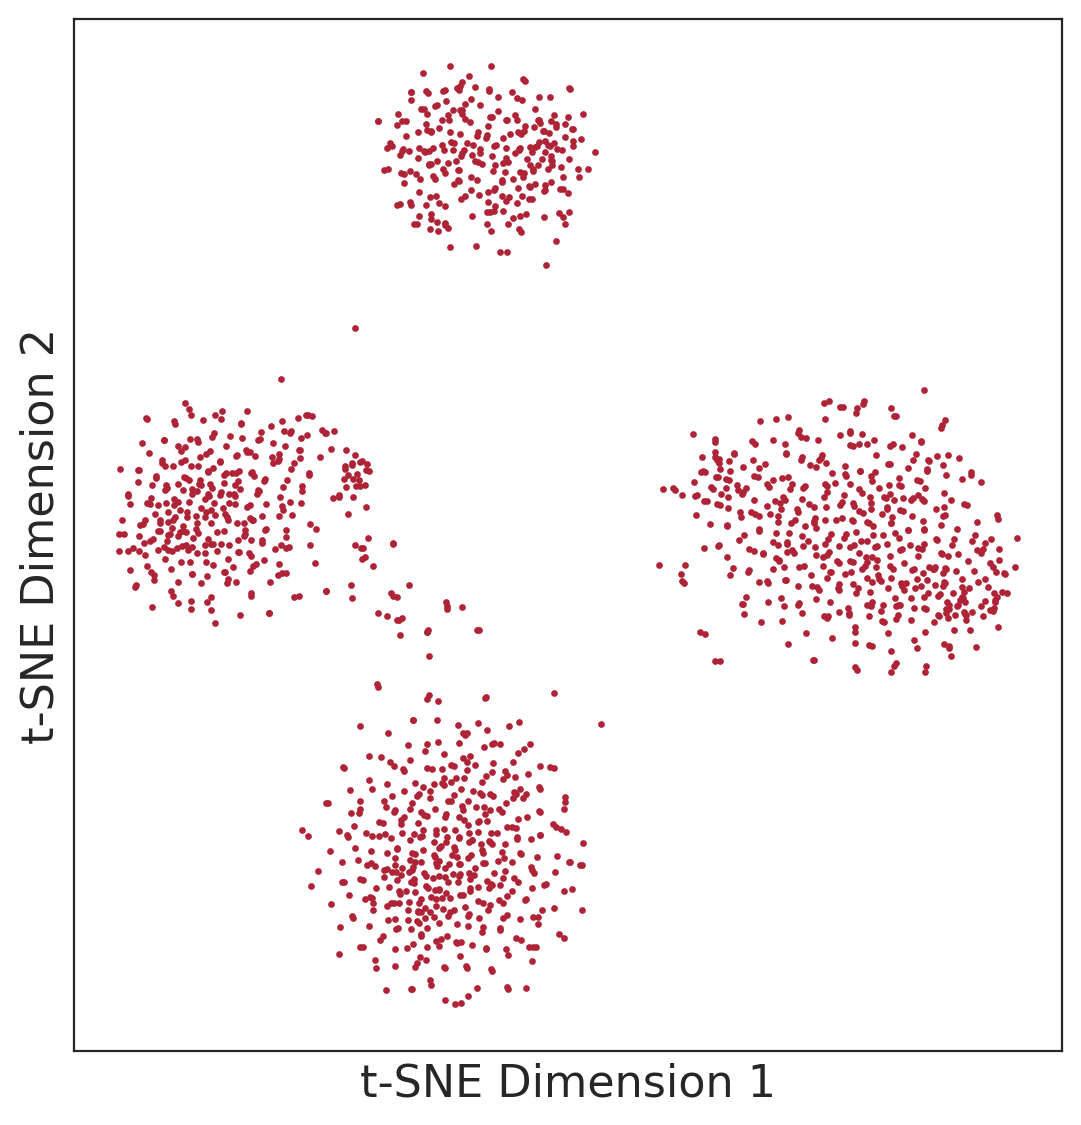

In [6]:
g = sns.FacetGrid(sample_info, height=6)
g.map(plt.scatter, 't-SNE Dimension 1', 't-SNE Dimension 2', s=2, color='#af2337')

g.ax.spines['top'].set_visible(True)
g.ax.spines['right'].set_visible(True)
g.ax.tick_params(left=False, bottom=False)
g.ax.set_xticks([])
g.ax.set_yticks([])

In [7]:
cluster = SpectralClustering(n_clusters=4,
                             n_jobs=-1,
                             affinity='nearest_neighbors',
                             random_state=42, n_neighbors=15,
                             assign_labels='discretize',
                             n_init=50).fit(lsi_r)
sample_info['cluster_labels'] = cluster.labels_

[]

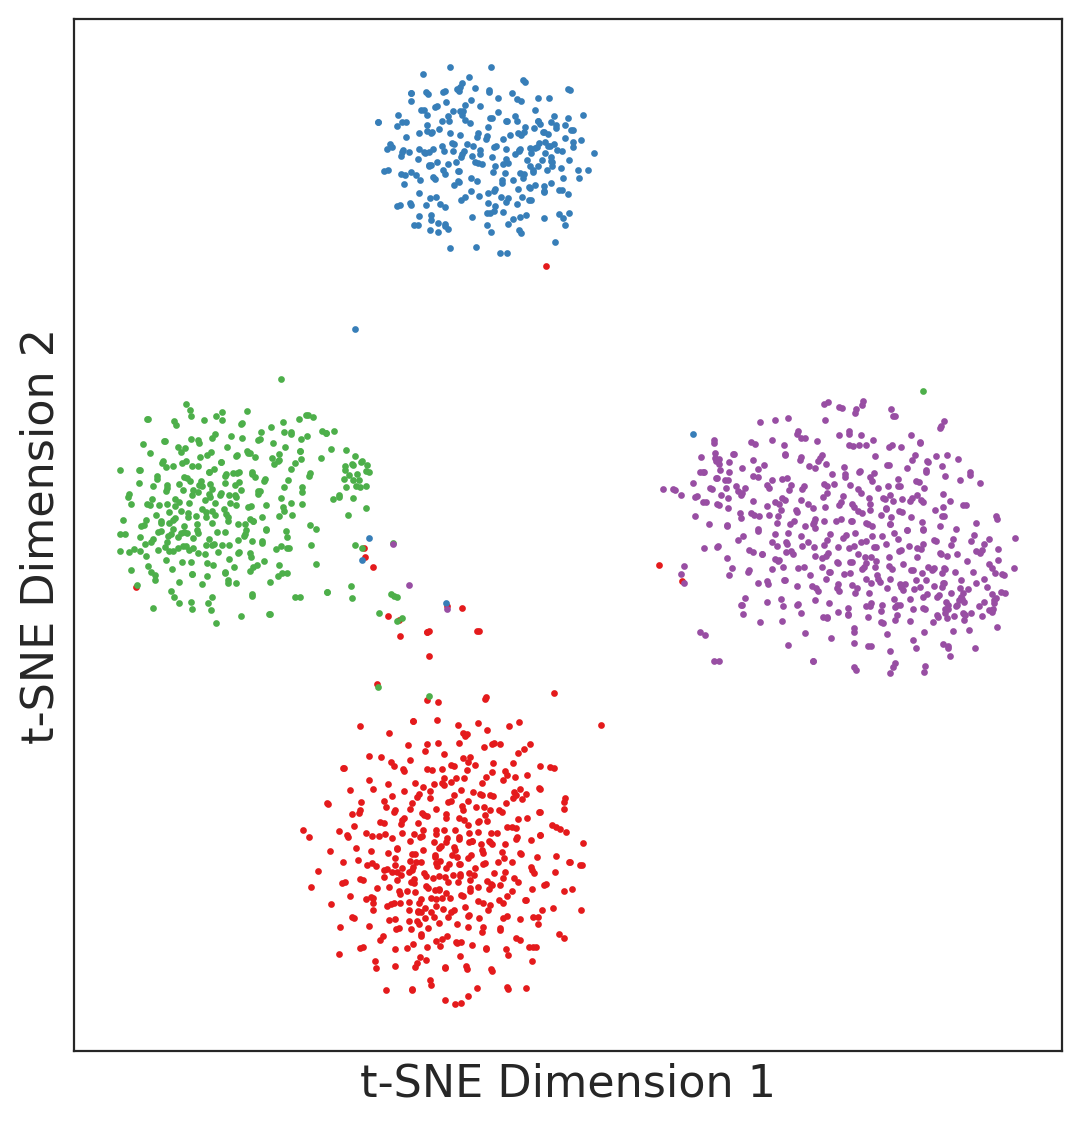

In [8]:
g = sns.FacetGrid(sample_info, hue='cluster_labels', height=6)
g.map(plt.scatter, 't-SNE Dimension 1', 't-SNE Dimension 2', s=2)

g.ax.spines['top'].set_visible(True)
g.ax.spines['right'].set_visible(True)
g.ax.tick_params(left=False, bottom=False)
g.ax.set_xticks([])
g.ax.set_yticks([])

In [9]:
# use logistic regression to find marker genes

from sklearn.model_selection import cross_val_score, StratifiedKFold

X = bin_rna.T
y = cluster.labels_

cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

logit = LogisticRegression(penalty='l2',
                           random_state=42,
                           solver='liblinear')
scores = cross_val_score(logit, X, y, cv=cv)
scores

array([0.98776758, 0.96625767, 0.98466258, 0.99386503, 0.98466258])

In [10]:
logit.fit(X, y)

LogisticRegression(random_state=42, solver='liblinear')

In [11]:
logit.classes_

array([0, 1, 2, 3])

In [12]:
marker_genes = pd.DataFrame({
               'class_': logit.classes_[logit.coef_.argmax(0)],
               'gene': X.columns,
               'weight': logit.coef_.max(0)
               })

marker_genes.query('weight > 0').shape

(17311, 3)

In [13]:
top_genes = (
            marker_genes.query('weight > 0.')
                        .sort_values('weight', ascending=False)
                        .groupby('class_')
                        .head(500)
                        .sort_values(['class_', 'weight'], ascending=[True, False])
            )

top_genes.head(5)

,class_,gene,weight
15489,0,TERF1,0.608581
12389,0,CD24,0.453039
22643,0,COX6A1,0.448862
22164,0,NAP1L1,0.447945
25237,0,SNHG14,0.438756


In [18]:
markers = pd.DataFrame(
                      data = (top_genes.groupby('class_')
                                       .head(10)['gene']
                                       .values.reshape(4, 10)
                                       .T
                              ),
                      columns = ['cluster{}'.format(i) for i in range(4)])
markers

,cluster0,cluster1,cluster2,cluster3
0,TERF1,MS4A1,PRAME,COL1A2
1,CD24,HLA-DRA,NMU,DCN
2,COX6A1,CD74,SDF2L1,LUM
3,NAP1L1,HLA-DRB1,HIST1H1C,IGFBP7
4,SNHG14,B2M,SNHG32,COL6A3
5,NOP56,HLA-B,SLC25A37,C1S
6,AASS,ID2,TXNIP,TIMP1
7,ESRG,IGHM,AIG1,CALD1
8,PHC1,HLA-C,RHAG,VIM
9,L1TD1,HLA-DPA1,MT-ND2,ANXA2


In [19]:
## based on the top markers

# cluster 0: H1
# cluster 1: GM12878
# cluster 2: K562
# cluster 3: BJ

sample_info['cell_line'] = sample_info['cluster_labels']
sample_info.replace({ 'cell_line' : {0 : 'H1', 1 : 'GM12878',
                                     2 : 'K562', 3 : 'BJ'} }, inplace=True)

In [20]:
sample_info.head()

,t-SNE Dimension 1,t-SNE Dimension 2,cluster_labels,cell_line
AAAAACGGCCTG,35.683216,-0.396028,3,BJ
AAAACACTCCTG,-10.243223,-30.465065,0,H1
AAAACCGGTACC,-8.667699,32.700386,1,GM12878
AAAACGCCTTTC,-16.773870,-25.915960,0,H1
AAAACTTAGCTG,23.386383,1.987568,3,BJ


In [21]:
# output metrics file

!mkdir -p RNA/H1 RNA/BJ RNA/GM12878 RNA/K562

for cl in ['H1', 'BJ', 'K562', 'GM12878']:
    tmp = rna.loc[:, sample_info.query("cell_line == @cl").index]
    out = pd.concat([tmp.sum(0), (tmp > 0).sum(0)], axis=1)
    out.columns = ['nCounts', 'nFeatures']
    out.to_csv('RNA/%s/metrics.csv' % cl, index_label='cell')

# Check ATAC data and ouput to each individual cell types

In [23]:
# No barcode reads available, so we directly download the count table from
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126074

!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE126074&format=file&file=GSE126074%5FCellLineMixture%5FSNAREseq%5Fchromatin%5Fcounts%2Etsv%2Egz' \
      -O ATAC/GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv.gz

dna = pd.read_csv('ATAC/GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv.gz',
                  sep='\t', compression='gzip')

In [28]:
dna.shape

(136771, 1047)

In [30]:
dna_info = sample_info.loc[dna.columns,]
dna_info

,t-SNE Dimension 1,t-SNE Dimension 2,cluster_labels,cell_line
ACTTTCTAATCA,43.688614,-8.298906,3,BJ
GAGAGAAAACCT,-34.970963,-3.047621,0,H1
TACGGCTGTTAT,-34.198166,2.390893,2,K562
GACGCGTAAGTG,41.201324,-4.963534,3,BJ
GAAAGGACTGCA,42.790066,-5.489700,3,BJ
...,...,...,...,...
GTTCTTCCTAGT,1.745847,-19.298018,0,H1
ATCCGTTCAACG,-9.468248,-16.750288,0,H1
CCGACTAAGAAT,-24.483263,8.599204,2,K562
AAGCCTGGGGGC,0.892062,-28.588219,0,H1


In [35]:
np.sum(dna_info.isna().sum(1))

0

In [36]:
sample_info['cell_line'].value_counts()

BJ         525
H1         471
K562       355
GM12878    280
Name: cell_line, dtype: int64

In [37]:
dna_info['cell_line'].value_counts()

H1         390
BJ         321
K562       198
GM12878    138
Name: cell_line, dtype: int64

In [38]:
# output metrics file

!mkdir -p ATAC/H1 ATAC/BJ ATAC/GM12878 ATAC/K562

In [39]:
for cl in ['H1', 'BJ', 'K562', 'GM12878']:
    tmp = dna.loc[:, dna_info.query("cell_line == @cl").index]
    out = pd.concat([tmp.sum(0), (tmp > 0).sum(0)], axis=1)
    out.columns = ['nCounts', 'nFeatures']
    out.to_csv('ATAC/%s/metrics.csv' % cl, index_label='cell')